### Import

In [1]:
import os
import json
import csv
import pandas as pd
import random
import numpy as np

from datetime import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

### Getting list of files

In [2]:
directory = './densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [3]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [4]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22383      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [5]:
# number of people in a frame

def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

### Getting names of files with 1 person

In [6]:
# getting only one person frames

# Setup lists to collect file paths
selected_files_ballet = []
selected_files_tap = []
selected_files_latin = []

# Identify all file names
for d in directories:
    if d == 'ballet':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_ballet.append(file_name)
    elif d == 'tap':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_tap.append(file_name)
    elif d == 'latin':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_latin.append(file_name)

# Print the sizes of the selected files lists
print("Number of selected files for ballet:", len(selected_files_ballet))
print("Number of selected files for tap:", len(selected_files_tap))
print("Number of selected files for latin:", len(selected_files_latin))



Number of selected files for ballet: 8341
Number of selected files for tap: 7078
Number of selected files for latin: 5355


### Comparing JSON files and PNG files to see if files both exist, removed if doesn't exist

In [7]:
ballet_dir = './densepose_skeletal/rgb/ballet'
ballet_skel = sorted(os.listdir(ballet_dir))

tap_dir = './densepose_skeletal/rgb/tap'
tap_skel = sorted(os.listdir(tap_dir))

latin_dir = './densepose_skeletal/rgb/latin'
latin_skel = sorted(os.listdir(latin_dir))

In [8]:
# Convert lists to sets
json_ballet = set([file.split('.')[0] for file in selected_files_ballet])  # removing the file extension
png_ballet = set([file.split('.')[0] for file in ballet_skel])  # removing the file extension

json_tap = set([file.split('.')[0] for file in selected_files_tap])  # removing the file extension
png_tap = set([file.split('.')[0] for file in tap_skel])  # removing the file extension

json_latin = set([file.split('.')[0] for file in selected_files_latin])  # removing the file extension
png_latin = set([file.split('.')[0] for file in latin_skel])  # removing the file extension

# Find common elements
common_ballet = list(sorted(json_ballet.intersection(png_ballet)))
common_tap = list(sorted(json_tap.intersection(png_tap)))
common_latin = list(sorted(json_latin.intersection(png_latin)))

filtered_selected_files_ballet = [file_name + ".png" for file_name in common_ballet]
filtered_selected_files_tap = [file_name + ".png" for file_name in common_tap]
filtered_selected_files_latin = [file_name + ".png" for file_name in common_latin]

In [9]:
# Print the sizes of the selected files lists
print("Number of selected files for ballet:", len(filtered_selected_files_ballet))
print("Number of selected files for tap:", len(filtered_selected_files_tap))
print("Number of selected files for tap:", len(filtered_selected_files_latin))

Number of selected files for ballet: 8338
Number of selected files for tap: 7078
Number of selected files for tap: 5346


### Function to alter name to png filename

In [10]:
def change_filename(imagefile):
    for file in range(len(imagefile)):
        original_string = imagefile[file]
    
        # replace .json with .jpg
        modified_string = original_string.replace('.json', '.png')
    
        # update list with modified string
        imagefile[file] = modified_string

In [11]:
change_filename(filtered_selected_files_ballet)

In [12]:
filtered_selected_files_ballet

['-sEgjXxjxIw_102_0026.png',
 '-sEgjXxjxIw_102_0055.png',
 '-sEgjXxjxIw_102_0060.png',
 '-sEgjXxjxIw_102_0075.png',
 '-sEgjXxjxIw_102_0077.png',
 '-sEgjXxjxIw_102_0079.png',
 '-sEgjXxjxIw_102_0080.png',
 '-sEgjXxjxIw_102_0081.png',
 '-sEgjXxjxIw_102_0082.png',
 '-sEgjXxjxIw_102_0083.png',
 '-sEgjXxjxIw_102_0084.png',
 '-sEgjXxjxIw_102_0085.png',
 '-sEgjXxjxIw_102_0086.png',
 '-sEgjXxjxIw_102_0087.png',
 '-sEgjXxjxIw_102_0088.png',
 '-sEgjXxjxIw_102_0089.png',
 '-sEgjXxjxIw_102_0090.png',
 '-sEgjXxjxIw_102_0091.png',
 '-sEgjXxjxIw_102_0092.png',
 '-sEgjXxjxIw_102_0093.png',
 '-sEgjXxjxIw_102_0094.png',
 '-sEgjXxjxIw_102_0095.png',
 '-sEgjXxjxIw_102_0096.png',
 '-sEgjXxjxIw_102_0097.png',
 '-sEgjXxjxIw_102_0098.png',
 '-sEgjXxjxIw_102_0099.png',
 '-sEgjXxjxIw_102_0100.png',
 '-sEgjXxjxIw_102_0101.png',
 '-sEgjXxjxIw_102_0102.png',
 '-sEgjXxjxIw_102_0103.png',
 '-sEgjXxjxIw_102_0104.png',
 '-sEgjXxjxIw_102_0105.png',
 '-sEgjXxjxIw_102_0106.png',
 '-sEgjXxjxIw_102_0107.png',
 '-sEgjXxjxIw_

In [13]:
change_filename(filtered_selected_files_tap)

In [14]:
filtered_selected_files_tap

['-ZxOm8B-BX4_020_0001.png',
 '-ZxOm8B-BX4_020_0002.png',
 '-ZxOm8B-BX4_020_0003.png',
 '-ZxOm8B-BX4_020_0004.png',
 '-ZxOm8B-BX4_020_0005.png',
 '-ZxOm8B-BX4_020_0006.png',
 '-ZxOm8B-BX4_020_0007.png',
 '-ZxOm8B-BX4_020_0008.png',
 '-ZxOm8B-BX4_020_0009.png',
 '-ZxOm8B-BX4_020_0010.png',
 '-ZxOm8B-BX4_020_0011.png',
 '-ZxOm8B-BX4_020_0012.png',
 '-ZxOm8B-BX4_020_0013.png',
 '-ZxOm8B-BX4_020_0014.png',
 '-ZxOm8B-BX4_020_0015.png',
 '-ZxOm8B-BX4_020_0016.png',
 '-ZxOm8B-BX4_020_0017.png',
 '-ZxOm8B-BX4_020_0018.png',
 '-ZxOm8B-BX4_020_0019.png',
 '-ZxOm8B-BX4_020_0020.png',
 '-ZxOm8B-BX4_020_0021.png',
 '-ZxOm8B-BX4_020_0022.png',
 '-ZxOm8B-BX4_020_0023.png',
 '-ZxOm8B-BX4_020_0024.png',
 '-ZxOm8B-BX4_020_0025.png',
 '-ZxOm8B-BX4_020_0026.png',
 '-ZxOm8B-BX4_020_0027.png',
 '-ZxOm8B-BX4_020_0028.png',
 '-ZxOm8B-BX4_020_0029.png',
 '-ZxOm8B-BX4_020_0030.png',
 '-ZxOm8B-BX4_020_0031.png',
 '-ZxOm8B-BX4_020_0032.png',
 '-ZxOm8B-BX4_020_0033.png',
 '-ZxOm8B-BX4_020_0034.png',
 '-ZxOm8B-BX4_

In [15]:
change_filename(filtered_selected_files_latin)

In [16]:
filtered_selected_files_latin

['01f-oLGZv1s_017_0004.png',
 '01f-oLGZv1s_017_0005.png',
 '01f-oLGZv1s_017_0006.png',
 '01f-oLGZv1s_017_0011.png',
 '01f-oLGZv1s_017_0012.png',
 '01f-oLGZv1s_017_0013.png',
 '01f-oLGZv1s_017_0015.png',
 '01f-oLGZv1s_017_0017.png',
 '01f-oLGZv1s_017_0019.png',
 '01f-oLGZv1s_017_0021.png',
 '01f-oLGZv1s_017_0023.png',
 '01f-oLGZv1s_017_0024.png',
 '01f-oLGZv1s_017_0025.png',
 '01f-oLGZv1s_017_0026.png',
 '01f-oLGZv1s_017_0027.png',
 '01f-oLGZv1s_017_0029.png',
 '01f-oLGZv1s_017_0030.png',
 '01f-oLGZv1s_017_0033.png',
 '01f-oLGZv1s_017_0034.png',
 '01f-oLGZv1s_017_0036.png',
 '01f-oLGZv1s_017_0037.png',
 '01f-oLGZv1s_017_0038.png',
 '01f-oLGZv1s_017_0041.png',
 '01f-oLGZv1s_017_0042.png',
 '01f-oLGZv1s_017_0043.png',
 '01f-oLGZv1s_017_0044.png',
 '01f-oLGZv1s_017_0045.png',
 '01f-oLGZv1s_017_0046.png',
 '01f-oLGZv1s_017_0047.png',
 '01f-oLGZv1s_017_0048.png',
 '01f-oLGZv1s_017_0049.png',
 '01f-oLGZv1s_017_0050.png',
 '01f-oLGZv1s_017_0051.png',
 '01f-oLGZv1s_017_0052.png',
 '01f-oLGZv1s_

### since images are too large, only get random of 300 images for each style

In [17]:
randomselected_files_ballet = random.sample(filtered_selected_files_ballet, 1000)
randomselected_files_ballet.sort()

In [18]:
randomselected_files_tap = random.sample(filtered_selected_files_tap, 1000)
randomselected_files_tap.sort()

In [19]:
randomselected_files_latin = random.sample(filtered_selected_files_latin, 1000)
randomselected_files_latin.sort()

## TEST on resize image

In [20]:
DATA_PATH_ballet = "./densepose_skeletal/rgb/ballet/"
DATA_PATH_tap = "./densepose_skeletal/rgb/tap/"
DATA_PATH_latin = "./densepose_skeletal/rgb/latin/"

In [21]:
image_path = os.path.join(DATA_PATH_ballet, '-sEgjXxjxIw_102_0026.png')
image = load_img(image_path)  
image_resized = image.resize((700, 400))

#### original image

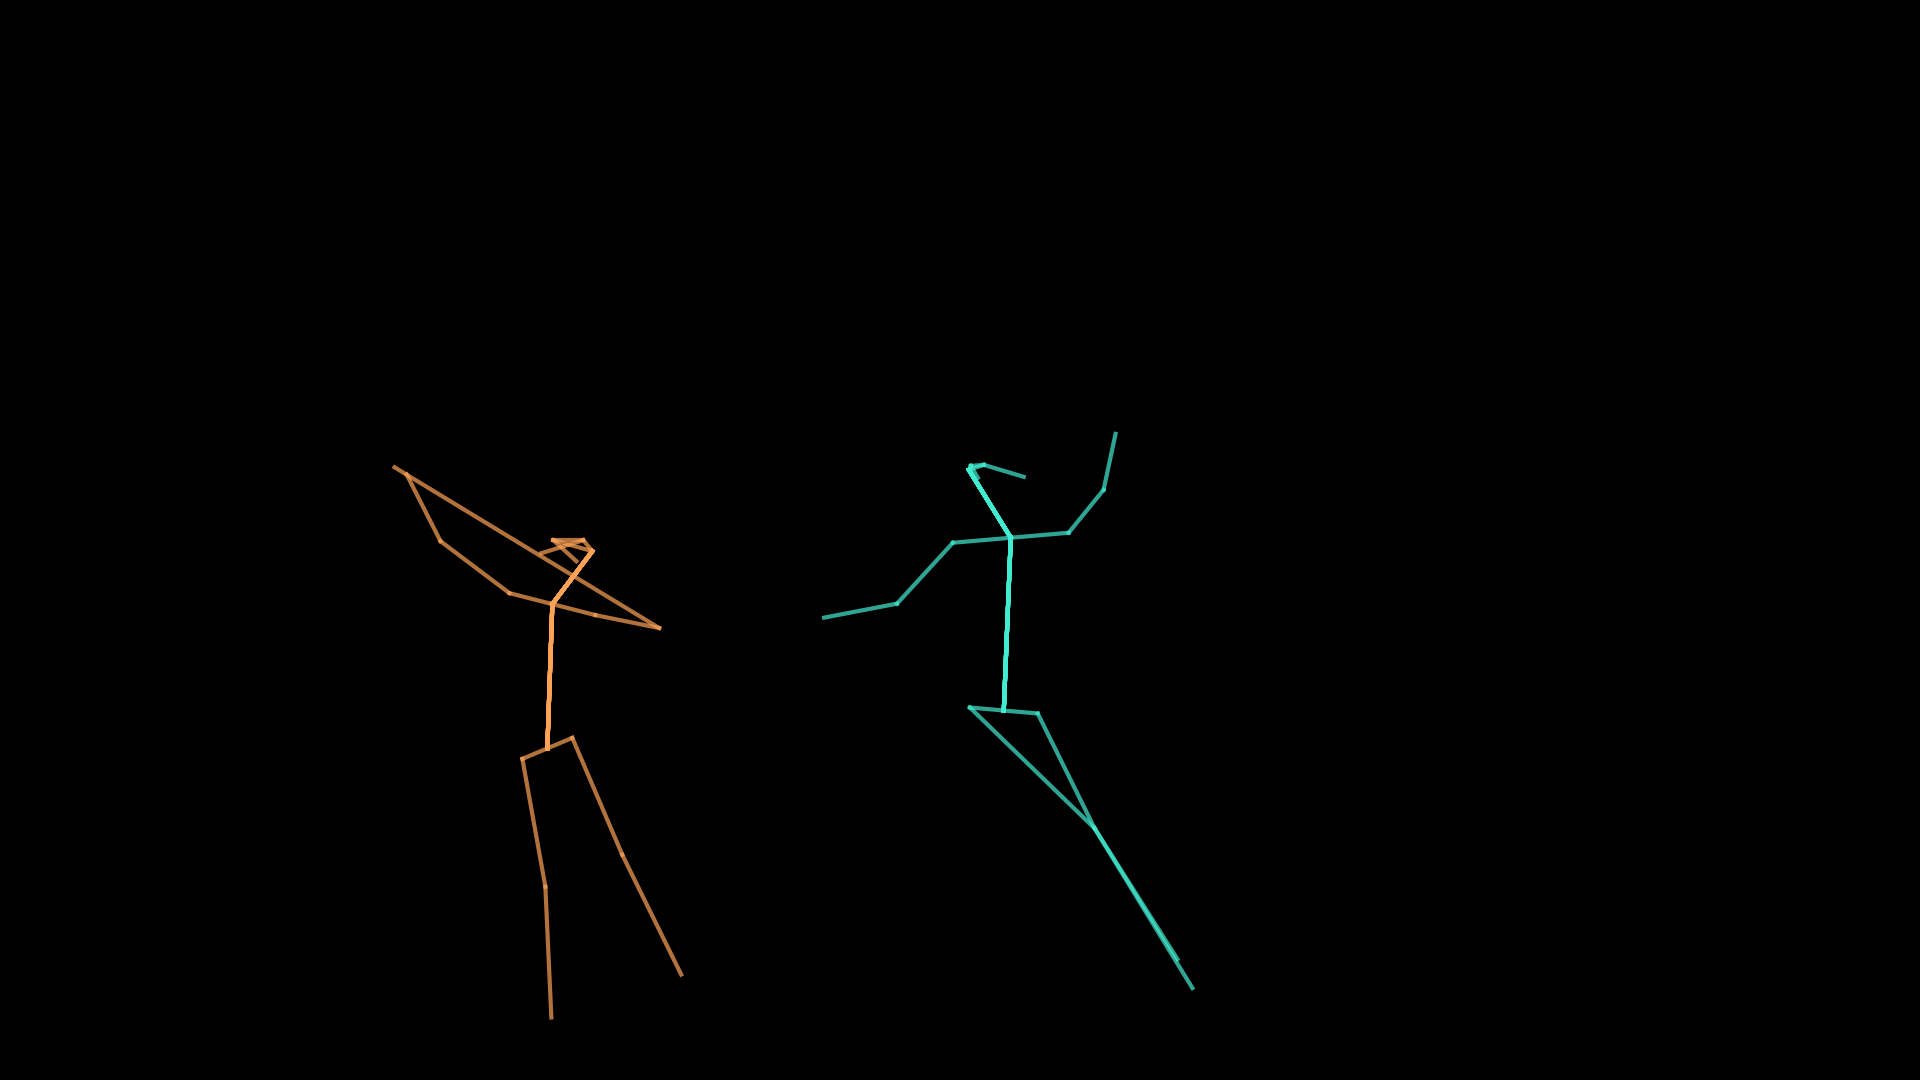

In [22]:
load_img(image_path)  

#### resized image

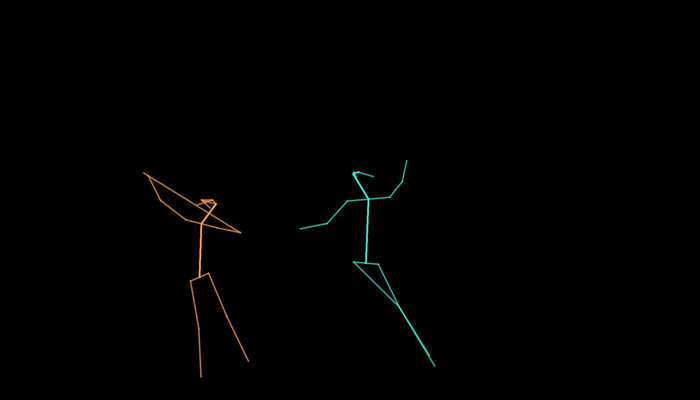

In [23]:
image_resized

## END of TEST

### Read data, load images and labels into arrays

In [24]:
images = []
labels = []

DATA_PATH_ballet = "./densepose_skeletal/rgb/ballet/"
DATA_PATH_tap = "./densepose_skeletal/rgb/tap/"
DATA_PATH_latin = "./densepose_skeletal/rgb/latin/"

In [25]:
for file in randomselected_files_ballet:
    image_path = os.path.join(DATA_PATH_ballet, file)

    ## image to array
    image = load_img(image_path)
    image_resized = image.resize((700, 400))                                  
    image_ar = img_to_array(image_resized)
    images.append(image_ar)

    ## create labels
    labels.append('ballet')

In [26]:
for file in randomselected_files_tap:
    image_path = os.path.join(DATA_PATH_tap, file)

    ## image to array
    image = load_img(image_path)                                  
    image_resized = image.resize((700, 400))                                  
    image_ar = img_to_array(image_resized)
    images.append(image_ar)

    ## create labels
    labels.append('tap')

In [27]:
for file in randomselected_files_latin:
    image_path = os.path.join(DATA_PATH_latin, file)

    ## image to array
    image = load_img(image_path)                                  
    image_resized = image.resize((700, 400))                                  
    image_ar = img_to_array(image_resized)
    images.append(image_ar)

    ## create labels
    labels.append('latin')

In [28]:
images = np.array(images)
labels = np.array(labels).flatten()

In [29]:
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (3000, 400, 700, 3)
Shape of labels  (3000,)


In [30]:
unique_labels = np.unique(labels)
norm_images = images/255

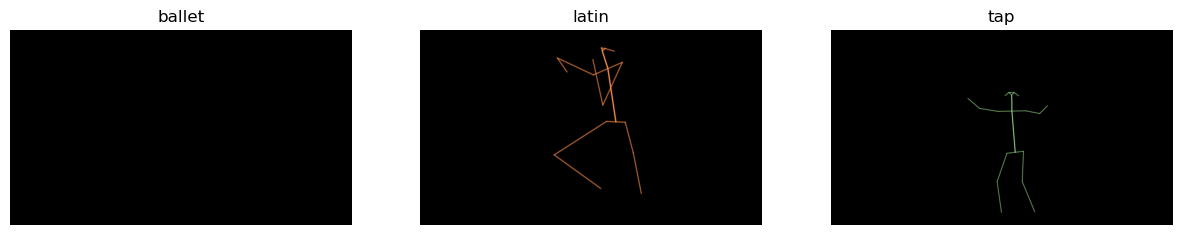

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

num_labels = len(unique_labels)

for idx in range(3):  # iteration over subplots
    if idx < num_labels:  # checking if idx is within range
        filtered_img = norm_images[labels == unique_labels[idx]]
        image = filtered_img[0] if len(filtered_img) > 0 else None
        if image is not None:
            axs[idx].imshow(image)
            axs[idx].set_title(unique_labels[idx])
            axs[idx].axis('off')

plt.show()

#### Encoding labels

In [33]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### splitting data

In [34]:
def split_data(images, labels, split):
    # Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    X, y = images[shuffle], labels[shuffle]
    
    # create data splits
    splitting = np.multiply(len(X), split).astype(int)
    X_train, X_val, X_test = np.split(X, [splitting[0], splitting[0] + splitting[1]])
    y_train, y_val, y_test = np.split(y, [splitting[0], splitting[0] + splitting[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [35]:
# Define splits
split = (0.6, 0.2, 0.2)

# Create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (1800, 400, 700, 3)
Shape of train labels  (1800,)
Shape of val images  (600, 400, 700, 3)
Shape of train labels  (600,)
Shape of test images  (600, 400, 700, 3)
Shape of test labels  (600,)


#### image transformation and augmentation

In [36]:
def data_preprocessing(X, y, data_partition='train'):
    '''
    Apply transformations and augmentations to training, validation, and test data

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.5
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, delta=DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.random_flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y_train
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X = X/255.0
    
    return X, y

In [37]:
# Apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (3600, 400, 700, 3)
Shape of train labels  (3600,)
Shape of val images  (600, 400, 700, 3)
Shape of test images  (600, 400, 700, 3)


In [38]:
# Compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# Reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# Print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 840000
Shape of train images  (3600, 840000)
Shape of train labels  (3600,)
Shape of val images  (600, 840000)
Shape of test images  (600, 840000)


In [39]:
## use training data on training model
rdm_frst_clsfr = ensemble.RandomForestClassifier(n_estimators=2, n_jobs=-1, random_state=7, max_depth=8).fit(X_train_re, y_train)

## predict train data and valid data
y_train_pred = rdm_frst_clsfr.predict(X_train_re)
y_val_pred = rdm_frst_clsfr.predict(X_val_re)
train_accuracy = accuracy_score(y_train_pred, y_train)
valid_accuracy = accuracy_score(y_val_pred, y_val)
print('Accuracy for Training: ', train_accuracy)
print('Accuracy for Validation: ', valid_accuracy)

Accuracy for Training:  0.5838888888888889
Accuracy for Validation:  0.35833333333333334


(array([0, 1, 2]),
 [Text(0, 0, 'ballet'), Text(1, 0, 'latin'), Text(2, 0, 'tap')])

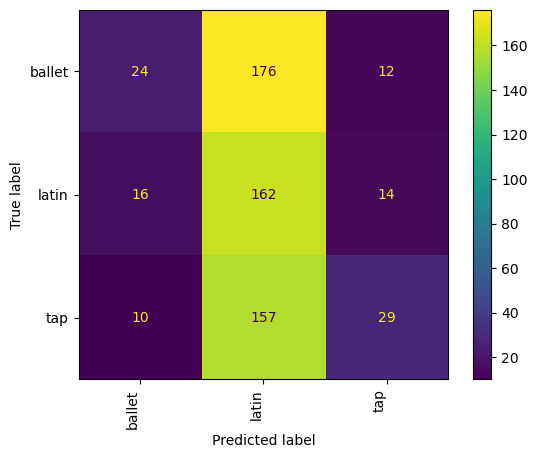

In [40]:
matrix = confusion_matrix(y_val, y_val_pred, normalize=None)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=encoded_labels_classes)

matrix_display.plot()
plt.xticks(rotation=90, ha='right')

In [41]:
rf_clf2 = ensemble.RandomForestClassifier(n_estimators=180, n_jobs=-1, random_state=7, max_depth=8).fit(X_train_re, y_train)

y_train_pred2 = rf_clf2.predict(X_train_re)
y_val_pred2 = rf_clf2.predict(X_val_re)
train_accuracy2 = accuracy_score(y_train_pred2, y_train)
valid_accuracy2 = accuracy_score(y_val_pred2, y_val)
print('Accuracy for Training: ', train_accuracy2)
print('Accuracy for Validation: ', valid_accuracy2)

Accuracy for Training:  0.7933333333333333
Accuracy for Validation:  0.5183333333333333


(array([0, 1, 2]),
 [Text(0, 0, 'ballet'), Text(1, 0, 'latin'), Text(2, 0, 'tap')])

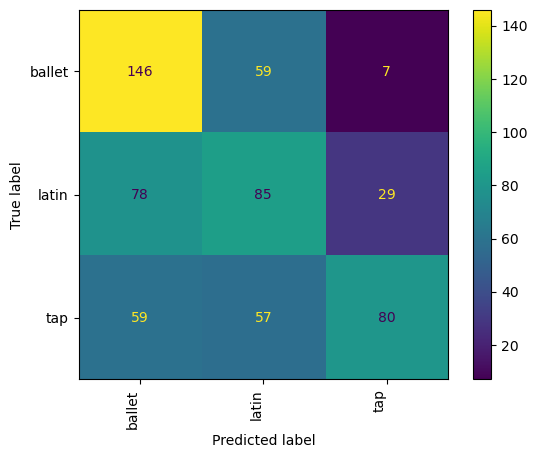

In [42]:
matrix = confusion_matrix(y_val, y_val_pred2, normalize=None)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=encoded_labels_classes)

matrix_display.plot()
plt.xticks(rotation=90, ha='right')